# PREDICTION DE VOLUMETRIE__PREMIERE VISUALISATION

**C'est un notebook où je teste des choses, les codes que j'ai utilisés et que j'ai présentés dans mon ppt et dans mon rapport sont dans le notebook "analyse de la source des tickets"**

### imports des modules et du dataset

In [1]:
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from prophet import Prophet
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, mean_absolute_error
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima import auto_arima
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from pandas.plotting import autocorrelation_plot


In [2]:
os.chdir('C:\\Users\\matthias.picard\\Downloads\\données consort')
statique=pd.read_excel('Static_data.xlsx')

In [3]:
statique.head()

,Ticket_id,Type_Ticket,Date_deb,Date_due,Date_res,Date_clo,Delai_att,Delai_res,Delai_clo,Content,...,Source,Solution,Entite,Priority,Impact,Urgency,Satisfaction,Satisfaction_comment,Problem_name,Location
0,134431,Demande,2020-09-29 10:10:30,2020-10-01 10:10:30,NaT,NaT,0.0,0.0,0.0,Description dÃ©taillÃ©e du changement=xxxxxxxx...,...,Directe,NaN,CONSORT NT,Basse,Bas,Moyenne,NaN,NaN,NaN,NaN
1,134430,Demande,2020-09-29 10:05:40,2020-10-01 10:05:40,NaT,NaT,0.0,0.0,0.0,Description dÃ©taillÃ©e du changement=xxxxxxxx...,...,Directe,NaN,CONSORT NT,Basse,Bas,Moyenne,NaN,NaN,NaN,NaN
2,134429,Demande,2020-09-29 09:47:36,2020-10-01 09:47:36,NaT,NaT,0.0,0.0,0.0,TEST,...,Directe,NaN,CONSORT NT,Basse,Bas,Moyenne,NaN,NaN,NaN,NaN
3,134428,Demande,2020-09-28 19:20:41,2020-09-30 18:30:00,NaT,NaT,0.0,0.0,0.0,test,...,Directe,NaN,CONSORT NT,Basse,Bas,Moyenne,NaN,NaN,NaN,NaN
4,134427,Demande,2020-09-28 18:33:17,2020-09-30 18:30:00,NaT,NaT,0.0,0.0,0.0,Ceci est un test,...,Directe,NaN,CONSORT NT,Basse,Bas,Moyenne,NaN,NaN,NaN,NaN


In [66]:
statique.Location.value_counts()

Cap Etoile                                                          1378
Castres                                                              376
Cap Etoile > Aile Pershing                                           313
Cap Etoile > Aile Centrale                                           307
Cap Etoile > Aile Gouvion                                            226
                                                                    ... 
Tour EVE > Salle Serveur                                               1
Bruxelles Washington                                                   1
Castres > LTE Lot 307 > StandAlone Hypervisors > PRDMUTHYPESX002       1
Cap Etoile > Stock deploiement                                         1
DC2-Courbevoie > Salle OB13                                            1
Name: Location, Length: 86, dtype: int64

Nous allons extraire de cette base de données le nombre de tickets par jour/heures/demi-journées. Notre repère temporel sera la colonne Date_deb 

In [15]:
#.values est pratique pour convertir une serie en tableau en gardant les memes informations
type(statique['Type_Ticket'].values)

numpy.ndarray

### Préparation des données

#### preparation de la colonne 'Date_deb'

In [3]:
statique.drop(np.arange(97253,97970,1), inplace=True)

entre les lignes 97253 et 97970 de la colonne Date_deb on ne retrouve que des nan. On est obligé de les enlever pour convertir la colonne en DateTime et s'en servir comme index temporelle

In [4]:
statique['Date_deb']=pd.to_datetime(statique['Date_deb'])

statique_heures=statique.copy()
statique_heures['Date_deb'] = statique_heures.Date_deb.dt.floor(freq='H') 
statique_heures.set_index('Date_deb',inplace=True)


statique_demijours=statique.copy()
statique_demijours['Date_deb'] = statique_demijours.Date_deb.dt.floor(freq='12h') 
statique_demijours.set_index('Date_deb',inplace=True)


statique_jours=statique.copy()
statique_jours['Date_deb'] = statique_jours.Date_deb.dt.floor(freq='D') 
statique_jours.set_index('Date_deb',inplace=True)


On met Date_deb en index, et on regroupe les tickets selon l'heure/le jour/ la moitié de journée de leur création

#### visualisation des nan

<AxesSubplot:ylabel='Date_deb'>

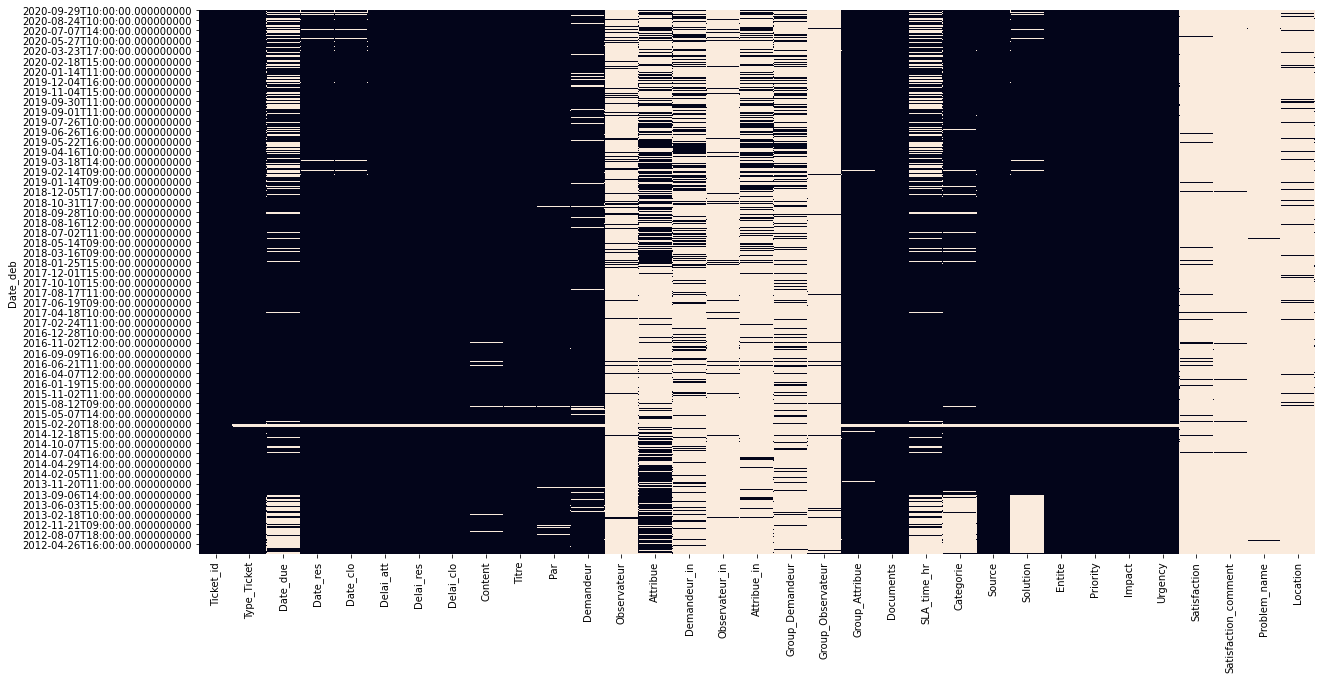

In [104]:
plt.figure(figsize=(20,10))
sns.heatmap(statique_heures.isna(), cbar=False)

In [103]:
(statique_heures.isna().sum()/statique_heures.shape[0]).sort_values(ascending=True)

Ticket_id               0.001976
Type_Ticket             0.005599
Delai_att               0.005599
Delai_res               0.005599
Delai_clo               0.005599
Documents               0.005615
Entite                  0.005615
Priority                0.005615
Impact                  0.005615
Source                  0.005615
Urgency                 0.005615
Titre                   0.005842
Group_Attribue          0.013441
Content                 0.014226
Date_res                0.016304
Date_clo                0.016390
Par                     0.020868
Demandeur               0.052879
Categorie               0.117678
Solution                0.123772
Date_due                0.231914
SLA_time_hr             0.238251
Attribue                0.533482
Demandeur_in            0.726091
Group_Demandeur         0.747351
Attribue_in             0.763247
Observateur             0.920152
Satisfaction            0.941474
Observateur_in          0.946023
Location                0.949866
Group_Obse

## Dataset géneral

#### creation d'un dataset avec le nombre de ticket crées par journées

In [5]:
nb_ticket_jours=pd.DataFrame(statique_jours.index.value_counts())
ticket_jours=nb_ticket_jours.reset_index().sort_values(by='index').set_index('index').asfreq('d')
ticket_jours[ticket_jours.isna()]=0
ticket_jours.rename(columns={'Date_deb':'nb_tickets'},inplace=True)
ticket_jours

,nb_tickets
index,
2011-10-17,1.0
2011-10-18,0.0
2011-10-19,0.0
2011-10-20,0.0
2011-10-21,0.0
...,...
2020-09-25,67.0
2020-09-26,3.0
2020-09-27,0.0


On crée un dataset qui nous donne le nombre de ticket crées par jours entre 2011-10-17 et 2020-09-28

####  creation d'un dataset avec le nombre de tickets créer par heures

In [6]:
nb_ticket_heures=pd.DataFrame(statique_heures.index.value_counts())
ticket_heures=nb_ticket_heures.reset_index().sort_values(by='index').set_index('index').asfreq('h')
ticket_heures[ticket_heures.isna()]=0
ticket_heures.rename(columns={'Date_deb':'nb_tickets'},inplace=True)
ticket_heures

,nb_tickets
index,
2011-10-17 14:00:00,1.0
2011-10-17 15:00:00,0.0
2011-10-17 16:00:00,0.0
2011-10-17 17:00:00,0.0
2011-10-17 18:00:00,0.0
...,...
2020-09-29 06:00:00,0.0
2020-09-29 07:00:00,0.0
2020-09-29 08:00:00,0.0


Pareil, mais par heure cette fois

### Data visualisation

#### nombre de tickets crées par heures,demi journées et journées, sur toute la période

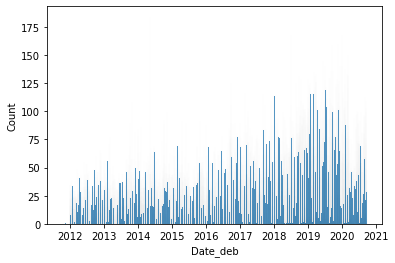

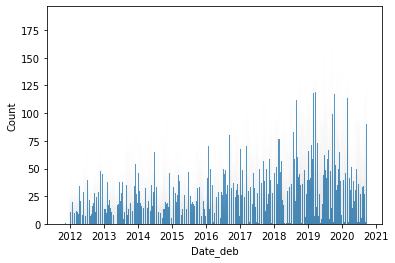

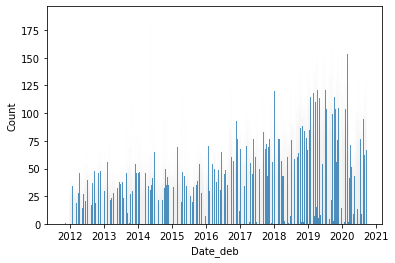

In [101]:
dataframe=[statique_heures,statique_demijours,statique_jours]

for df in dataframe:
    plt.figure()
    sns.histplot(df.index,bins=5000)


On observe une tendance à la hausse assez clair dans tout les graphes jusqu'à 2020, où le nombre de tickt s'est mis à baisser

#### Nombre de tickets crée par jours sur toute la période

<AxesSubplot:xlabel='index'>

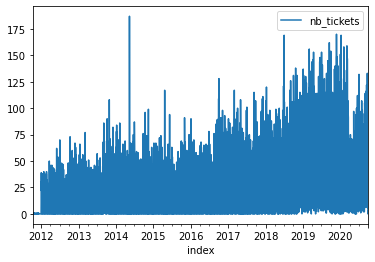

In [7]:
ticket_jours.plot()

**repartition des tickets par mois**

<AxesSubplot:xlabel='index'>

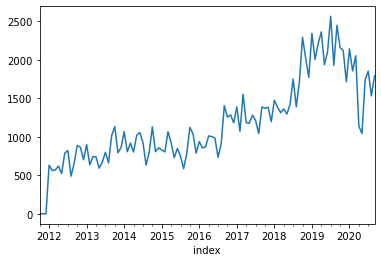

In [35]:
ticket_heures['nb_tickets'].resample('M').sum().plot()

(graphe semblable à ceux du dessus)

#### repartition des tickets par heures de la journées ( en moyenne)

<AxesSubplot:xlabel='index', ylabel='Date_deb'>

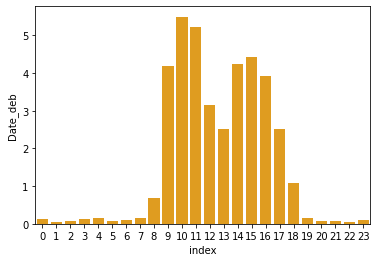

In [133]:
rpj=ticket_heures.groupby(ticket_heures.index.hour).mean()
sns.barplot(data=rpj.reset_index(),x='index',y='nb_tickets',color='orange')

Les heures du matin (entre 9h et 12h) sont celles où le nombre de tickets crées par heure est la plus importante. Ce nombre chute entre 12h et 13h ( pause déjeuner?), avant de remonter l'après-lidi, mais des proportions inférieurs au matin

#### repartition des tickets par mois ( en moyenne)

<AxesSubplot:xlabel='index', ylabel='Date_deb'>

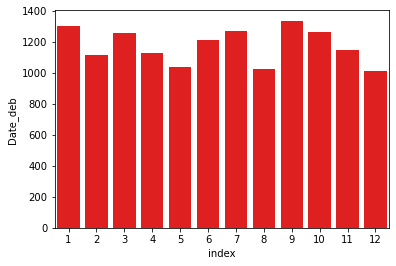

In [125]:
rpm=ticket_heures.resample('M').sum()
rpm2=rpm.groupby(rpm.index.month).mean()
sns.barplot(data=rpm2.reset_index(),y='nb_tickets',x='index',color='red')

Le nombre de ticket crées par heure est assez homogène. On constate que les mois de vacances voient moins de tickets crées et que les mois de rentrée ( janvier et septembre)sont ceux avec le plus de tickets crées

#### repartition des tickets  par heures en moyenne selon les jour de la semaine

<AxesSubplot:xlabel='jours de la semaine', ylabel='Date_deb'>

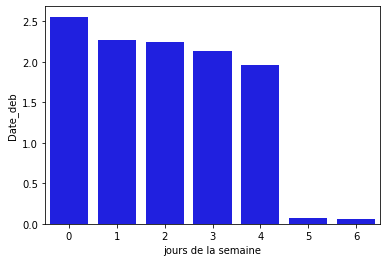

In [126]:
ticket_heures_jds=ticket_heures.copy()
ticket_heures_jds['jours de la semaine']=ticket_heures_jds.index.dayofweek
jds=ticket_heures_jds.groupby(['jours de la semaine']).mean()
sns.barplot(data=jds.reset_index(),y='nb_tickets',x='jours de la semaine',color='blue')

(ce graphe ne represente pas le nombre de tickets crées par jours de la semaine en moyenne, mais le nombre de tickets crées par heures en moyenne lors 'un jour de la semaine')

Proportion la plus importante lundi, qui baisse progressivement tout au long de la semaine, puis deviens très proche de zéro le week-end

### Prophet simple (par jours)

#### creation d'un test_set et d'un train_set

In [42]:
ticket_jours_prophet=ticket_jours.reset_index().rename(columns={'index':'ds','nb_tickets':'y'})

trainset_simple_prophet=ticket_jours_prophet.loc[:'3000',:]
testset_simple_prophet=ticket_jours_prophet.loc['3000':,:]


In [43]:
model_simple_prophet = Prophet(daily_seasonality=True)
model_simple_prophet.fit(trainset_simple_prophet)
future_simple_prophet = model_simple_prophet.make_future_dataframe(periods=271)
forecast_simple_prophet = model_simple_prophet.predict(future_simple_prophet)


INFO:numexpr.utils:NumExpr defaulting to 4 threads.


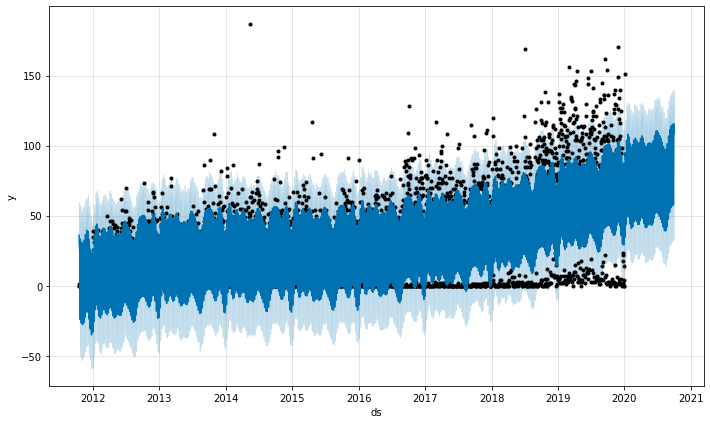

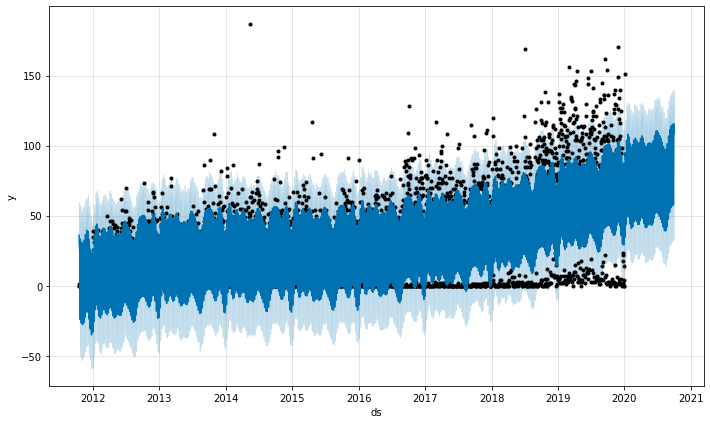

In [44]:
model_simple_prophet.plot(forecast_simple_prophet)

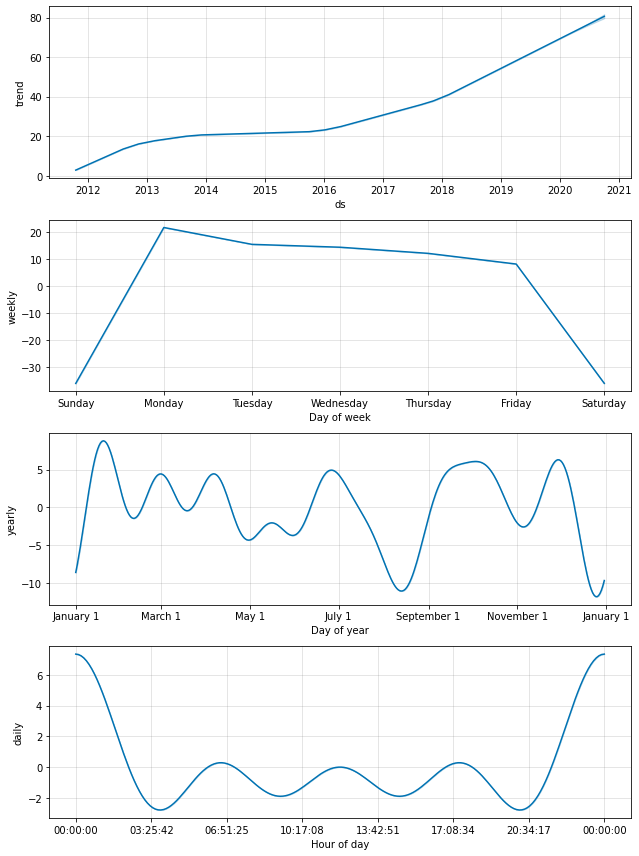

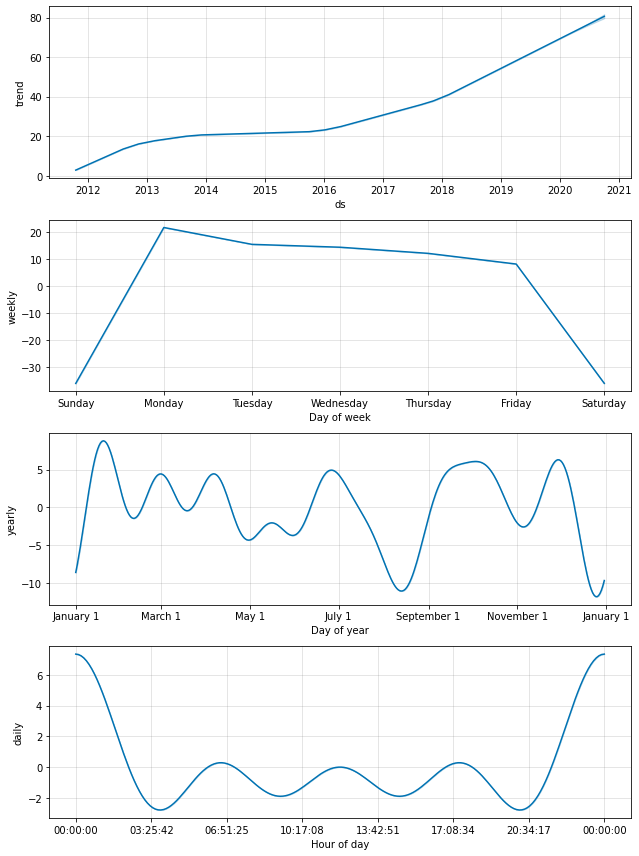

In [45]:
model_simple_prophet.plot_components(forecast_simple_prophet)

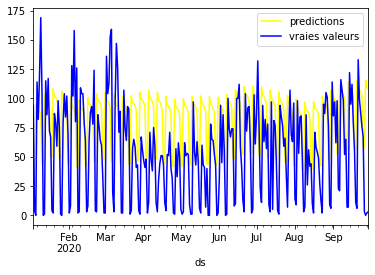

In [46]:
predictions_simple_prophet=pd.DataFrame(forecast_simple_prophet.loc[3001:,'yhat'])
predictions_simple_prophet.set_index(testset_simple_prophet['ds'],inplace=True)
plt.figure()
predictions_simple_prophet['yhat'].plot(c='yellow',label='predictions')
plt.plot(testset_simple_prophet['ds'],testset_simple_prophet['y'],c='blue',label='vraies valeurs')
plt.legend()

Prophet prend bien en compte la saisonnalité par jours, et arrive à detecter les fluctuations entre les mois (moins de tickets en août, plus en septembre...). Mais la variance entre chaque jours est trop faible ( d'ailleur, Prophet ne prédira jamais qu'il y aura un jours avec moins de 30 tickets crées). L'espérance de toutes les prédictions est aussi legerement supérieur à celle des valeurs réels. En effet Prophet suit la tendance entre 2011 et 2019, qui montrait une hausse progressive du nombre de ticket, mais il ne prend pas en compte les effets du confinement, qui a fait baisser cette tendance.

In [47]:
(mean_squared_error(testset_simple_prophet['y'],predictions_simple_prophet['yhat']),
mean_absolute_percentage_error(testset_simple_prophet['y'],predictions_simple_prophet['yhat']))

(2521.7909058672994, 9881569755778438.0)

Le 'mean_absolute_percentage_error' (valeur de droite), a une valeur assez aberrante...

### Prophet preprocessé

In [ ]:
prophet_test_predict = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

### Utilisation d'ARIMA

ARIMA ne peut marcher que sur des modèles stationnaires, c'est à dire que la variance, l'espérance, et la covariance doivent rester stable au cours du temps. On ne doit pas ooserver de tendance à la hausse, ni à la baisse, la période doit rester constante et  l'amplitude du signal à chaque période doit rester la même.

On a déja pu constater qu'il existait une tendance dans nos donnée. On pourrait donc considérer que nous ne sommes pas dans un cas stationnaire. Pour vérifier cela nous allons aussi effectuer un test ADF. Si la p-value est inférieur à 0,05, on peut considerer que nos données sont stationnaires

####  (test ADF)

In [49]:
result = adfuller(ticket_jours['nb_tickets'].values)
result

(-3.3891086852030674,
 0.01133580672767429,
 27,
 3243,
 {'1%': -3.432368033803368,
  '5%': -2.8624316464349073,
  '10%': -2.5672446426683},
 27937.48812949941)

p-value: 0.01133580672767429 (deuxième valeur dans le tuple). Pourtant, on avait identifier une tendance! Dans le doute nous allons transformer nos données de sorte à les rendre stationnaire: 

#### stationnarisation ( même si le test ADF semble déja valider la stationnarité)

Tout les graphes representent les tickets crées par mois pour plus de lisibilité (les données sont réparties par jours)

Données de base:

<AxesSubplot:xlabel='index'>

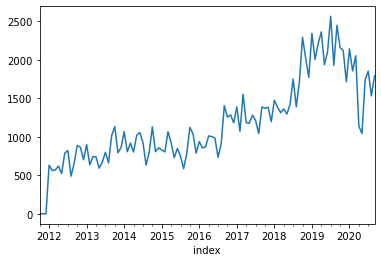

In [53]:
ticket_jours['nb_tickets'].resample('M').sum().plot()

In [51]:
ticket_jours_arima=ticket_jours.copy()

On va d'abord enlever la variation de la variance au cours du temps, pour cela, on applique la fonction racine-carré

<AxesSubplot:xlabel='index'>

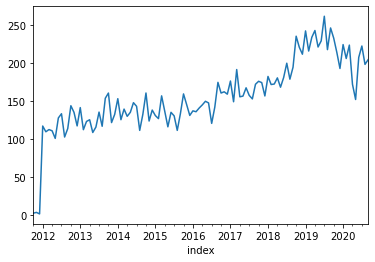

In [22]:
#transformation
ticket_jours_arima['nb_tickets_sqrt'] = np.sqrt(ticket_jours_arima['nb_tickets'])
ticket_jours_arima['nb_tickets_sqrt'].resample('M').sum().plot()

Puis on enleve la saisonnalité en utilisant une fonction de différentiation, qui va effacer les motifs récurrents

<AxesSubplot:xlabel='index'>

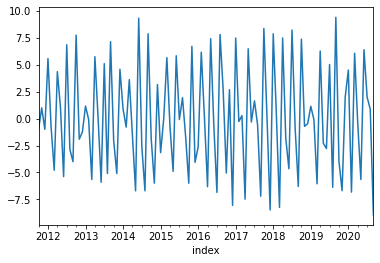

In [23]:
#différentiation
ticket_jours_arima_diff = np.diff(ticket_jours_arima['nb_tickets_sqrt'])
ticket_jours_arima['nb_tickets_sqrt_diff']=np.append([0], ticket_jours_arima_diff)
ticket_jours_arima['nb_tickets_sqrt_diff'].resample('M').sum().plot()

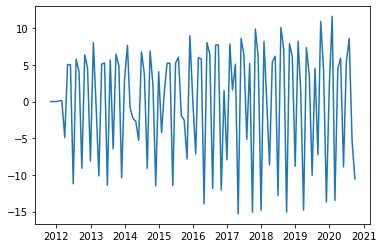

In [40]:
plt.plot(ticket_jours_arima['nb_tickets_sqrt_diff'].resample('M').sum() - ticket_jours_arima['nb_tickets_sqrt_diff'].shift(12).resample('M').sum()) 

On refait un test ADF: 

In [42]:
 adfuller(ticket_jours_arima['nb_tickets_sqrt_diff'].values)

(-18.06523953528895,
 2.614205225982096e-30,
 26,
 3244,
 {'1%': -3.4323674112281393,
  '5%': -2.8624313714499374,
  '10%': -2.5672444962719756},
 11829.254389960486)

La p-value est maintenant completement négligeable, essayons d'appliquer le modèle ARIMA avec nos nouvelles données

#### test arima

In [54]:
trainset_simple_arima=ticket_jours_arima.reset_index().loc[:'3000',:].set_index('index')
testset_simple_arima=ticket_jours_arima.reset_index().loc['3000':,:].set_index('index')

(impossible d'appliquer ARIMA avec nos données transformées, on applique ARIMA sur les données de base ci-dessous, en attendant )

In [48]:
model_arima = ARIMA(endog=trainset_simple_arima['nb_tickets'], order=(1,1,1))
model_arima_fit = model_arima.fit()

y_pred, se, conf = model_arima_fit.forecast(271)

print(mean_absolute_percentage_error(testset_simple_arima['nb_tickets_sqrt_diff'], y_pred),
 math.sqrt(mean_squared_error(testset_simple_arima['nb_tickets_sqrt_diff'], y_pred)))

1.0842647638556e+16 72.89973456348048


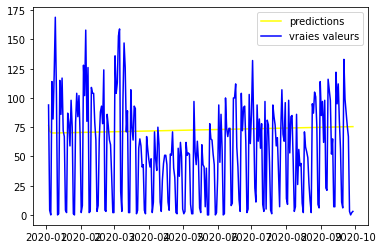

In [49]:
plt.figure()
plt.plot(testset_simple['ds'],y_pred,c='yellow',label='predictions')
plt.plot(testset_simple['ds'],testset_simple['y'],c='blue',label='vraies valeurs')
plt.legend()

ARIMA ne detecte aucune saisonnalité et se contente de rester au niveau de l'espérance....

#### AUTO-ARIMA pour SARIMAX

In [14]:
model = auto_arima(trainset_simple_arima['nb_tickets_sqrt_diff'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      start_d=0,max_d=2,           # let model determine 'd'
                      seasonal=True,     # No Seasonality
                      P=1, 
                      D=1, 
                       Q=1,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=14.76 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=19610.172, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=18057.210, Time=1.74 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=9.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=19608.172, Time=0.13 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=19596.773, Time=0.25 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=17323.538, Time=5.87 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=24.42 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.85 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=17379.029, Time=4.29 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=14.30 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=28.25 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=15.41 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=15336.679, Time=16.11 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AI

In [19]:
model_auto_sarimax = SARIMAX(endog=trainset_simple_arima['nb_tickets'], order=(3,0,2),seasonal_order=(2,1,0,12))
model_auto_sarimax_fit = model_auto_sarimax.fit()

predictions_sarimax1= model_auto_sarimax_fit.forecast(271)

6095524620579953.0 55.43055582026568


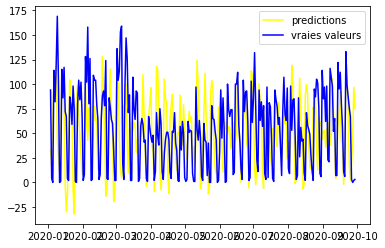

In [29]:
plt.figure()
plt.plot(testset_simple_arima.index,predictions_sarimax1,c='yellow',label='predictions')
plt.plot(testset_simple_arima.index,testset_simple_arima['nb_tickets'],c='blue',label='vraies valeurs')
plt.legend()

In [58]:
print(mean_absolute_percentage_error(testset_simple_arima['nb_tickets'], predictions_sarimax1),
 math.sqrt(mean_squared_error(testset_simple_arima['nb_tickets'], predictions_sarimax1)))

6095524620579953.0 46.2595054258481


Le modèle prend mieux en compte la saisonnalité mais semble toujours surestimé le nombre de ticket crée. De plus il affiche des valeurs négatives.